In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip
!unzip -qq -o Food-5K.zip
!ls
!ls Food-5K/training
!mv Food-5K/* .

--2021-10-28 21:17:53--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  14.4MB/s    in 34s     

2021-10-28 21:18:28 (12.6 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]

Food-5K  Food-5K.zip  __MACOSX	sample_data
0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1

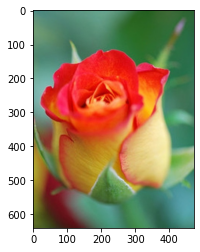

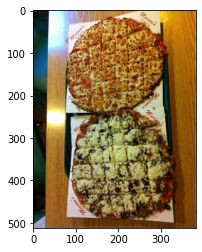

In [3]:
plt.imshow(image.load_img('training/0_808.jpg'))
plt.show()

plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

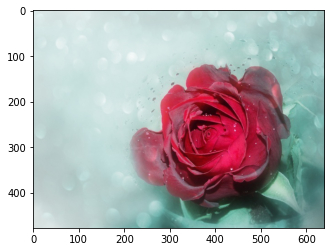

In [4]:
!mkdir data

# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

train_path = 'data/train'
valid_path = 'data/test'

# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

# useful for getting number of classes
folders = glob(train_path + '/*')
folders

# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [5]:
vgg_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# freeze pretrained model weights
vgg_model.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [6]:
# Keras image data generator returns classes one-hot encoded

K = len(folders) # number of classes

x = Flatten()(vgg_model.output)
x = Dense(K, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [7]:
batch_size = 128

gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
24/24 [==============================] - 143s 4s/step - loss: 1.3930 - accuracy: 0.9293 - val_loss: 0.9736 - val_accuracy: 0.9690
Epoch 2/10
24/24 [==============================] - 56s 2s/step - loss: 0.6327 - accuracy: 0.9720 - val_loss: 0.6766 - val_accuracy: 0.9810
Epoch 3/10
24/24 [==============================] - 56s 2s/step - loss: 0.3595 - accuracy: 0.9803 - val_loss: 0.5372 - val_accuracy: 0.9810
Epoch 4/10
24/24 [==============================] - 56s 2s/step - loss: 0.3259 - accuracy: 0.9843 - val_loss: 1.1310 - val_accuracy: 0.9710
Epoch 5/10
24/24 [==============================] - 56s 2s/step - loss: 0.1950 - accuracy: 0.9900 - val_loss: 0.7288 - val_accuracy: 0.9830
Epoch 6/10
24/24 [==============================] - 56s 2s/step - loss: 0.1384 - accuracy: 0.9897 - val_loss: 0.5622 - val_accuracy: 0.9840
Epoch 7/10
24/24 [==============================] - 56s 2s/step - loss: 0.1150 - accuracy: 0.9923 - val_loss: 0.5055 - val_accuracy: 0.9830
Epoch 8/10
24/24 [=

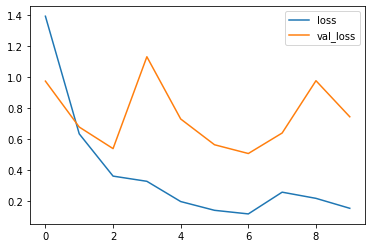

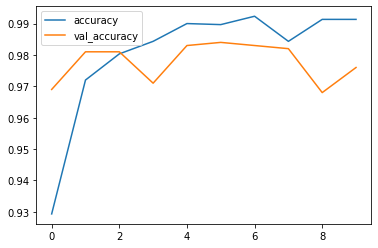

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()